#**Q2: Text Generation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Dependencies**

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, GRU
from keras.utils import np_utils

#**Part 1**

**Reading dataset.txt**

In [3]:
path_to_file = "/content/drive/MyDrive/dataset.txt"
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('{} characters'.format(len(text)))

1107542 characters


**Getting a list of unique characters**

In [4]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

80 unique characters


**Pre-processing**

In [5]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [6]:
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))

  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '6' :  17,
  '7' :  18,
  '9' :  19,


**Creating training examples and targets**

In [7]:
seq_length = 200
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()] , end = "")

HARRY

In [8]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'HARRY POTTER AND THE GOBLET OF FIRE\n\nCHAPTER ONE - THE RIDDLE HOUSE\n\n\tThe villagers of Little Hangleron still called it "the Riddle House," even though it had been many years since the Riddle family ha'
'd lived there.  It stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face.  Once a fine-looking manor, and easily t'
'he largest and grandest building for miles around, the Riddle House was now damp, derelict, and unoccupied.\n\tThe Little Hagletons all agreed that the old house was "creepy."  Half a century ago, someth'
'ing strange and horrible had happened there, something that the older inhabitants of the village still liked to discuss when topics for gossip were scarce.  The story had been picked over so many times'
', and had been embroidered in so many places, that nobody was quite sure what the truth was anymore.  Every version of the tale, however, started in the same place:  Fifty year

**Mapping function**

In [9]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

**Creating training batches**

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 200), dtype=tf.int64, name=None), TensorSpec(shape=(64, 200), dtype=tf.int64, name=None))>

In [11]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1500

**Define the model**

**1. Embedding layer** : The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions.

**2. LSTM layer** : A type of RNN with size units=rnn_units.

**3. Dense layer** : The output layer, with vocab_size outputs and 'RELU' as the activation fuction.

**4. Dropout layer** : Benifits regularisation and prevents overfitting

In [12]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
                               
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
  
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),

    tf.keras.layers.Dense(vocab_size,activation='relu'),
    
    tf.keras.layers.Dropout(0.2)
  ])
  return model

In [13]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [14]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "(batch_size, sequence_length, vocab_size)")

(64, 200, 80) (batch_size, sequence_length, vocab_size)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           20480     
                                                                 
 lstm (LSTM)                 (64, None, 1500)          10542000  
                                                                 
 dense (Dense)               (64, None, 80)            120080    
                                                                 
 dropout (Dropout)           (64, None, 80)            0         
                                                                 
Total params: 10,682,560
Trainable params: 10,682,560
Non-trainable params: 0
_________________________________________________________________


In [16]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, "(batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 200, 80) (batch_size, sequence_length, vocab_size)
scalar_loss:       4.381857


In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss=loss, metrics = 'accuracy')

In [19]:
history = model.fit(dataset, epochs= 50, callbacks=[callback])

Epoch 1/50
86/86 [==============================] - 26s 259ms/step - loss: 3.9377 - accuracy: 0.1216
Epoch 2/50
86/86 [==============================] - 25s 274ms/step - loss: 3.4941 - accuracy: 0.2242
Epoch 3/50
86/86 [==============================] - 26s 294ms/step - loss: 2.9998 - accuracy: 0.3322
Epoch 4/50
86/86 [==============================] - 27s 303ms/step - loss: 2.6416 - accuracy: 0.3943
Epoch 5/50
86/86 [==============================] - 26s 291ms/step - loss: 2.4904 - accuracy: 0.4330
Epoch 6/50
86/86 [==============================] - 28s 306ms/step - loss: 2.3742 - accuracy: 0.4614
Epoch 7/50
86/86 [==============================] - 27s 297ms/step - loss: 2.2834 - accuracy: 0.4839
Epoch 8/50
86/86 [==============================] - 27s 303ms/step - loss: 2.2014 - accuracy: 0.5013
Epoch 9/50
86/86 [==============================] - 27s 297ms/step - loss: 2.1441 - accuracy: 0.5143
Epoch 10/50
86/86 [==============================] - 27s 295ms/step - loss: 2.0969 - accura

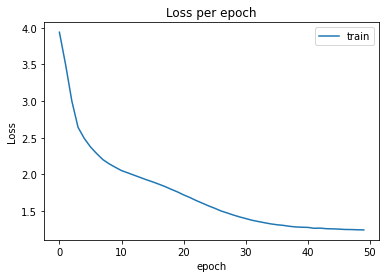

In [20]:
plt.plot(history.history['loss'])
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

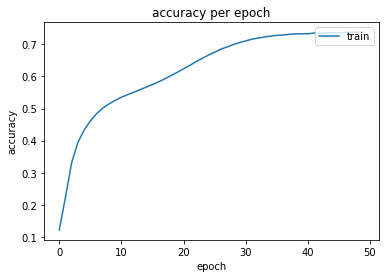

In [21]:
plt.plot(history.history['accuracy'])
plt.title('accuracy per epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

**Generating Words**

In [22]:
model.reset_states()
sample = 'HARRY POTTER AND THE GOBLET OF FIRE'
sample_vector = [char2idx[s] for s in sample]
predicted = sample_vector
sample_tensor = tf.expand_dims(sample_vector, 0) 
sample_tensor = tf.repeat(sample_tensor, 64, axis=0)


temperature = 0.6
for i in range(1000):
    pred = model(sample_tensor)
    pred = pred[0].numpy()/temperature
    pred = tf.random.categorical(pred, num_samples=1)[-1,0].numpy()
    predicted.append(pred)
    sample_tensor = predicted[-99:]
    sample_tensor = tf.expand_dims([pred],0)
    sample_tensor = tf.repeat(sample_tensor, 64, axis=0)
    
pred_char = [vocab[i] for i in predicted]
generated = ''.join(pred_char)
print(generated)

HARRY POTTER AND THE GOBLET OF FIRE

EA:

A Barty Quidditch team, the Neville g_t involved with him when he zouched ?MO to HhpiüNe.  The surface of the water was almost voice.
"XI - 7(could he ^:E Xver tjudü anX /(could have easSnelnuster, Neville XSne"
- Harry sMi•gs down the stone steps, out into the clouB7?  at Voldemort's father nervously as possible toward him.  Harry could see Madam Pomfrey fussing over Hermione, •zeF, B_/r?  Wurry didN't seem to be very difficult to see out of them.  They s'queJ6 the third task, My zoo	use TheUrt; it f•yVoldemort stood on tip of it and pointing to the kitchenKN.
"The "Th2Karkaroff's supporterpfkinnroI4 to rest on de
"That's not the point musttince 1Hen," she said. "1f Ju) a Jre7?"
"Yeago," said Harry.
"I see," said xising like zeFQthe look on Harry's face.  "Ministry was pleased. Ind Quidditch team Sirius ha
"There's a wayzPoff tallJY - you will come and have a look," said Harry, pointing to a large patH  XJown quickly from the stairs Wormtail h

**1. Sparse Categorical Crossentropy**

**In part 1, we use sparse_categorical_crossentropy as loss function.**

**loss = 1.2430**

#**Part 2**

**2. Mean Squared Error(MSE)**

**loss = 7.05**


In [36]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [37]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
history = model.fit(dataset, epochs= 10)

Epoch 1/10
86/86 [==============================] - 28s 304ms/step - loss: 7.0297
Epoch 2/10
86/86 [==============================] - 27s 297ms/step - loss: 7.0434
Epoch 3/10
86/86 [==============================] - 27s 297ms/step - loss: 7.0328
Epoch 4/10
86/86 [==============================] - 27s 298ms/step - loss: 7.0266
Epoch 5/10
86/86 [==============================] - 24s 263ms/step - loss: 7.0559
Epoch 6/10
86/86 [==============================] - 24s 265ms/step - loss: 7.0389
Epoch 7/10
86/86 [==============================] - 24s 267ms/step - loss: 7.0371
Epoch 8/10
86/86 [==============================] - 24s 269ms/step - loss: 7.0362
Epoch 9/10
86/86 [==============================] - 24s 267ms/step - loss: 7.0409
Epoch 10/10
86/86 [==============================] - 24s 262ms/step - loss: 7.0535


**3. Mean Absolute Error(MAE)**

**loss = 7.0047**

In [29]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [24]:
history = model.fit(dataset, epochs= 10, callbacks=[callback])

Epoch 1/10
86/86 [==============================] - 29s 303ms/step - loss: 6.0270
Epoch 2/10
86/86 [==============================] - 28s 311ms/step - loss: 5.5349
Epoch 3/10
86/86 [==============================] - 25s 273ms/step - loss: 6.5195
Epoch 4/10
86/86 [==============================] - 25s 272ms/step - loss: 6.9942
Epoch 5/10
86/86 [==============================] - 24s 264ms/step - loss: 7.0047


#**Part 3**

**In part 1, we use Adam as optimizer.**

**loss = 1.2430, accuracy = 0.7377**

**2. SGD**

**loss = 7.69**

In [19]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy')

In [20]:
history = model.fit(dataset, epochs= 10, callbacks=[callback])

Epoch 1/10
86/86 [==============================] - 28s 294ms/step - loss: 7.6880
Epoch 2/10
86/86 [==============================] - 27s 300ms/step - loss: 7.6908
Epoch 3/10
86/86 [==============================] - 26s 291ms/step - loss: 7.6924
Epoch 4/10
86/86 [==============================] - 28s 307ms/step - loss: 7.6788
Epoch 5/10
86/86 [==============================] - 26s 289ms/step - loss: 7.6894
Epoch 6/10
86/86 [==============================] - 27s 304ms/step - loss: 7.6873
Epoch 7/10
86/86 [==============================] - 26s 290ms/step - loss: 7.6922


**3. Nadam**

**loss = 7.03**

In [22]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy')

In [23]:
history = model.fit(dataset, epochs= 10, callbacks=[callback])

Epoch 1/10
86/86 [==============================] - 29s 303ms/step - loss: 6.1675
Epoch 2/10
86/86 [==============================] - 28s 307ms/step - loss: 5.7675
Epoch 3/10
86/86 [==============================] - 27s 301ms/step - loss: 5.8680
Epoch 4/10
86/86 [==============================] - 28s 306ms/step - loss: 6.7698
Epoch 5/10
86/86 [==============================] - 26s 290ms/step - loss: 7.0355


**Conclusion** **:** **The best loss function for this problem is Sparse Categorical Crossentropy and best optimizer is Adam**


**Loss Function**| **Loss**
--- | ---
**Sparse Categorical Crossentropy**| **1.2430**
**Mean Squared Error(MSE)**| **7.05**
**Mean Absolute Error(MAE)**| **7.0047**




**Optimizer**| **Loss**
--- | ---
**Adam**| **1.2430**
**SGD**| **7.69**
**Nadam**| **7.03**


# **Part 4**

**LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering
information for long periods of time is practically their default behavior, not something they
struggle to learn!
For predicting data in sequence we can use deep learning models like RNN or LSTM. LSTM can
be used to predict the next word. The neural network take sequence of words as input and
output will be a matrix of probability for each word from dictionary to be next of given
sequence.**